In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
df = spark.read.csv('/opt/gago/datasets/dataset.csv', header=True)

df.printSchema()

root
 |-- ano: string (nullable = true)
 |-- modelo: string (nullable = true)
 |-- preco: string (nullable = true)
 |-- kilometragem: string (nullable = true)
 |-- cor: string (nullable = true)
 |-- transmissao: string (nullable = true)



# Questões:

1. Quais as 3 cores dos veículos mais vendidos?

In [3]:
from pyspark.sql import functions as F

In [4]:
df.groupBy('cor').count().orderBy(F.desc('count')).show(3)

+--------+-----+
|     cor|count|
+--------+-----+
|   Preto|   35|
|   Prata|   32|
|Vermelho|   25|
+--------+-----+
only showing top 3 rows



2. De qual ano são os veículos mais vendidos?

In [5]:
veiculos_por_ano = df.groupBy('ano').count().orderBy(F.desc('count'))
veiculos_por_ano.show()

+----+-----+
| ano|count|
+----+-----+
|2010|   49|
|2009|   42|
|2011|   16|
|2008|   14|
|2007|   11|
|2006|    6|
|2000|    3|
|2004|    3|
|2005|    2|
|2012|    1|
|2002|    1|
|2003|    1|
|2001|    1|
+----+-----+



3. Crie um barplot para apresentar sua resposta no item 2.

In [6]:
veiculos_por_ano.toPandas().plot.bar(x='ano', y='count');

4. Qual o percentual de vendas de veículos com transmissão automática?
5. Crie um Pie Chart para representar sua resposta no item 4.

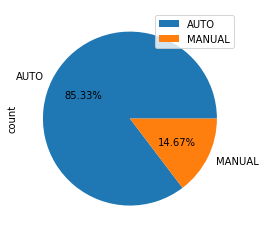

In [7]:
df.groupBy('transmissao').count().toPandas().set_index('transmissao').plot.pie(y='count', autopct='%.2f%%');

6. Qual o percentual de venda de veículos por modelo?

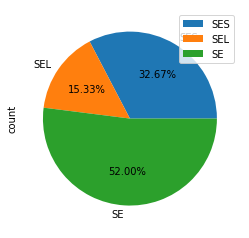

In [8]:
df.groupBy('modelo').count().toPandas().set_index('modelo').plot.pie(y='count', autopct='%.2f%%');

7. Calcule o percentual de vendas por preço de veículo e o percentual acumulado.

In [9]:
#https://medium.com/jbennetcodes/how-to-get-rid-of-loops-and-use-window-functions-in-pandas-or-spark-sql-907f274850e4

from pyspark.sql.window import Window

def calc_percent_and_percentile(df, col):
    w = Window.partitionBy('together_we_stand').orderBy(col)

    total = df.count()
    
    return (df.groupBy(col).count()
        .withColumn('together_we_stand', F.udf(lambda x: 1)('count'))
        .withColumn('percent', F.udf(lambda cnt: cnt*100/total)('count'))
        .withColumn('price_percentile', F.sum('percent').over(w))
    )

calc_percent_and_percentile(df, 'preco').show(2000000)

+-----+-----+-----------------+------------------+------------------+
|preco|count|together_we_stand|           percent|  price_percentile|
+-----+-----+-----------------+------------------+------------------+
|10000|    1|                1|0.6666666666666666|0.6666666666666666|
|10717|    1|                1|0.6666666666666666|1.3333333333333333|
|10770|    1|                1|0.6666666666666666|               2.0|
|10815|    1|                1|0.6666666666666666|2.6666666666666665|
|10836|    1|                1|0.6666666666666666| 3.333333333333333|
|10955|    2|                1|1.3333333333333333| 4.666666666666666|
|10979|    1|                1|0.6666666666666666| 5.333333333333333|
|10995|    3|                1|               2.0| 7.333333333333333|
|11450|    1|                1|0.6666666666666666|               8.0|
|11495|    1|                1|0.6666666666666666| 8.666666666666666|
|11749|    1|                1|0.6666666666666666| 9.333333333333332|
|11754|    1|       

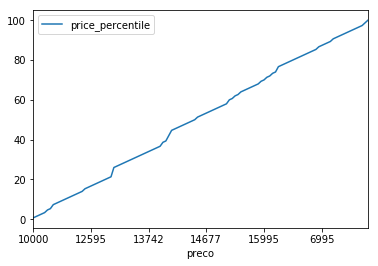

In [10]:
calc_percent_and_percentile(df, 'preco').toPandas().plot.line(x='preco', y='price_percentile')

8. Liste o total de veículos vendidos por ano e por tipo de transmissão (Dica: uma tabela de contingência faz isso para você com um comando).

In [11]:
df.stat.crosstab('ano', 'transmissao').show()

+---------------+----+------+
|ano_transmissao|AUTO|MANUAL|
+---------------+----+------+
|           2003|   1|     0|
|           2002|   1|     0|
|           2007|   7|     4|
|           2004|   3|     0|
|           2011|  16|     0|
|           2001|   1|     0|
|           2008|  10|     4|
|           2012|   1|     0|
|           2005|   2|     0|
|           2010|  42|     7|
|           2009|  36|     6|
|           2000|   3|     0|
|           2006|   5|     1|
+---------------+----+------+



9. Imprima um resumo estatístico com o teste do qui-quadrado, graus de liberdade e valor p do resultado do item anterior.

In [12]:
#https://runawayhorse001.github.io/LearningApacheSpark/exploration.html

In [13]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import types as T

ctab = (df
    .crosstab('ano', 'transmissao')
    .withColumn('ano_int', F.udf(lambda x: int(x), T.IntegerType())('ano_transmissao'))
    .withColumn('features', F.udf(lambda x,y: Vector.dense(x, y), VectorUDT())('AUTO', 'MANUAL'))
)


from pyspark.ml.stat import ChiSquareTest

# data = [(0.0, Vectors.dense(0.5, 10.0)),
#         (0.0, Vectors.dense(1.5, 20.0)),
#         (1.0, Vectors.dense(1.5, 30.0)),
#         (0.0, Vectors.dense(3.5, 30.0)),
#         (0.0, Vectors.dense(3.5, 40.0)),
#         (1.0, Vectors.dense(3.5, 40.0))]
# df = spark.createDataFrame(data, ["label", "features"])

r = ChiSquareTest.test(ctab, "features", "ano_int").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

Py4JJavaError: An error occurred while calling z:org.apache.spark.ml.stat.ChiSquareTest.test.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 56.0 failed 1 times, most recent failure: Lost task 0.0 in stage 56.0 (TID 2424, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 83, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-13-5980302d2d77>", line 7, in <lambda>
NameError: name 'Vector' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:390)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:409)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1337)
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1378)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1377)
	at org.apache.spark.mllib.stat.test.ChiSqTest$.chiSquaredFeatures(ChiSqTest.scala:86)
	at org.apache.spark.mllib.stat.Statistics$.chiSqTest(Statistics.scala:176)
	at org.apache.spark.ml.stat.ChiSquareTest$.test(ChiSquareTest.scala:75)
	at org.apache.spark.ml.stat.ChiSquareTest.test(ChiSquareTest.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 83, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-13-5980302d2d77>", line 7, in <lambda>
NameError: name 'Vector' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:390)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:409)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
from pyspark.ml.stat import ChiSquareTest

tab = df.crosstab('ano', 'transmissao').withColumn('ano_int', F.udf(lambda x: int(x))('ano_transmissao'))

r = ChiSquareTest.test(tab, 'ano_int', 'AUTO').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

10. Crie um barplot a partir do resultado do item 8.